# Energy modeling for DP cold room
- This analysis will look at the Dispatch (DP) cold room to build an energy model and estimate potential savings using a 4 dC setpoint instead of 2 dC.
- The results will also be compared with the basic estimate used in EDA.

In [51]:
# import libraries
import sys
import os
import numpy as np
import pandas as pd
import math
from scipy import stats
import sklearn.metrics as sklm
import sklearn.model_selection as ms
from sklearn import preprocessing
import joblib
import json
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    KFold,
    cross_val_score,
    cross_val_predict,
)
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import xgboost as xgb
import colorlover as cl
from sqlalchemy import create_engine

#SHapley Additive exPlanations (SHAP)
import shap

# configs
pd.options.display.float_format = "{:,.2f}".format
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 6
pio.templates.default = "plotly_white"

In [53]:
# load custom functions
sys.path.append("../")
from cnrdlib import cl_ml as clml

In [54]:
# load daily data from eda notebook
engine = create_engine(f"sqlite:///../data/RawData.db")
df = pd.read_sql_table("DailyDataEnergy", con=engine, index_col="timestamp")
df.head()

,CDD_calc,WIP_energy,DP_energy,WIP_temp,DP_temp,Ext_temp,DP_setpoint
timestamp,,,,,,,
2021-03-30,15.32,110.54,71.60,4.43,3.40,19.32,low
2021-03-31,19.23,168.87,65.99,6.68,5.37,23.23,high
2021-04-01,20.87,217.91,79.20,6.81,5.01,24.87,high
2021-04-02,18.14,180.26,67.72,4.66,3.03,22.14,low
2021-04-03,16.73,81.34,65.36,5.87,2.94,20.73,low


In [55]:
# add day of the week
df["day_of_week"] = df.index.dayofweek
df.head()

,CDD_calc,WIP_energy,DP_energy,WIP_temp,DP_temp,Ext_temp,DP_setpoint,day_of_week
timestamp,,,,,,,,
2021-03-30,15.32,110.54,71.60,4.43,3.40,19.32,low,1
2021-03-31,19.23,168.87,65.99,6.68,5.37,23.23,high,2
2021-04-01,20.87,217.91,79.20,6.81,5.01,24.87,high,3
2021-04-02,18.14,180.26,67.72,4.66,3.03,22.14,low,4
2021-04-03,16.73,81.34,65.36,5.87,2.94,20.73,low,5


In [56]:
len(df[df.DP_setpoint == "high"])

53

In [57]:
len(df[df.DP_setpoint == "low"])

61

- Good split of data with 53 days at the high setpoint and 61 days at the low setpoint.

# Create baseline model
- The high setpoint will be used as the baseline.
- The low setpoint will be used as the reporting period to calculate the additional energy used.

In [59]:
df_bl = df[df.DP_setpoint == "high"]
df_rp = df[df.DP_setpoint == "low"]

In [60]:
# feat_cols = ["DP_temp", "Ext_temp", "CDD_calc"]
feat_cols = ["DP_temp", "Ext_temp"]
print(feat_cols)

feat_labs_cols = feat_cols + ["DP_energy"]
print(feat_labs_cols)

['DP_temp', 'Ext_temp']
['DP_temp', 'Ext_temp', 'DP_energy']


In [61]:
# split features into numpy array
features = np.array(df_bl[feat_cols])
print(features.shape)

(53, 2)


In [62]:
p = features.shape[1]
print(p)

2


In [63]:
label = np.array(df_bl["DP_energy"])

In [64]:
# train-test split
np.random.seed(9988)

indx = range(features.shape[0])
indx = ms.train_test_split(
    indx,
    test_size=0.35,
)

x_train = features[indx[0], :]
y_train = np.ravel(label[indx[0]])
x_test = features[indx[1], :]
y_test = np.ravel(label[indx[1]])

In [65]:
# scale features
scaler = preprocessing.StandardScaler().fit(x_train[:, :])
x_train[:, :] = scaler.transform(x_train[:, :])
x_test[:, :] = scaler.transform(x_test[:, :])

# save scaler model
joblib.dump(scaler, "../models/model_feature_scaling.pkl")

x_train[:5, :]

array([[-2.3124682 ,  0.15754293],
       [ 0.20594279,  0.49606691],
       [ 1.23995545, -0.41256219],
       [-0.64022175, -1.17344798],
       [ 1.19388719, -1.51316336]])

# Linear model
Base reference

In [66]:
x_train_constant = sm.add_constant(x_train)
x_test_constant = sm.add_constant(x_test)

In [67]:
model_lin = sm.OLS(y_train, x_train_constant)
model_lin_fit = model_lin.fit()
model_lin_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     29.01
Date:                Mon, 30 Aug 2021   Prob (F-statistic):           7.93e-08
Time:                        22:00:59   Log-Likelihood:                -104.12
No. Observations:                  34   AIC:                             214.2
Df Residuals:                      31   BIC:                             218.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.2878      0.929     56.277      0.000      50.393      54.183
x1            -0.7721      0.935     -0.825      0.415      -2.680       1.136
x2             6.9454      0.935      7.424      0.000       5.037       8.853
==============================================================================
Omnibus:                       14.077   Durbin-Watson:                   2.489
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.620
Skew:                           1.108   Prob(JB):                     0.000149
Kurtosis:                       5.743   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
y_hat = model_lin_fit.predict(x_train_constant)

In [69]:
clml.regression_metrics(y_train, y_hat, p)

Root Mean Square Error = 5.17
Mean Absolute Error    = 3.48
Median Absolute Error  = 1.68
R^2                    = 0.6518
Adjusted R^2           = 0.6409


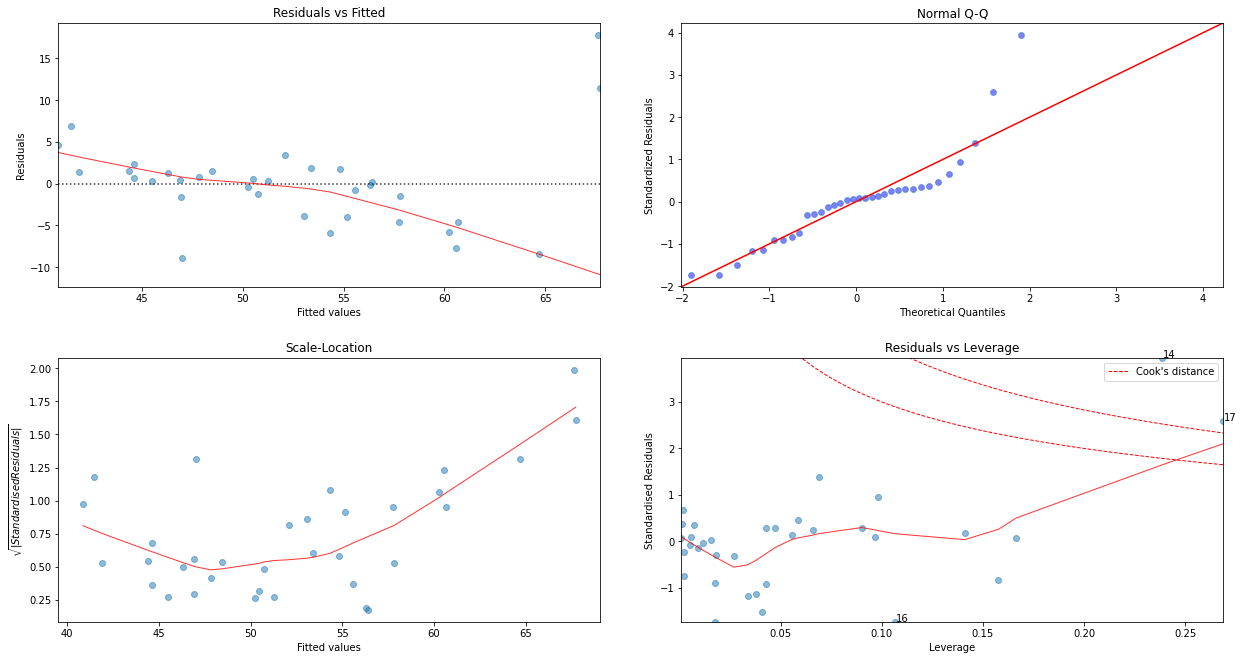

In [70]:
clml.diagnostic_plots(x_train, y_train, y_hat)

In [71]:
y_score = model_lin_fit.predict(x_test_constant)
clml.regression_metrics(y_test, y_score, p)

Root Mean Square Error = 6.06
Mean Absolute Error    = 4.94
Median Absolute Error  = 3.83
R^2                    = 0.5090
Adjusted R^2           = 0.4801


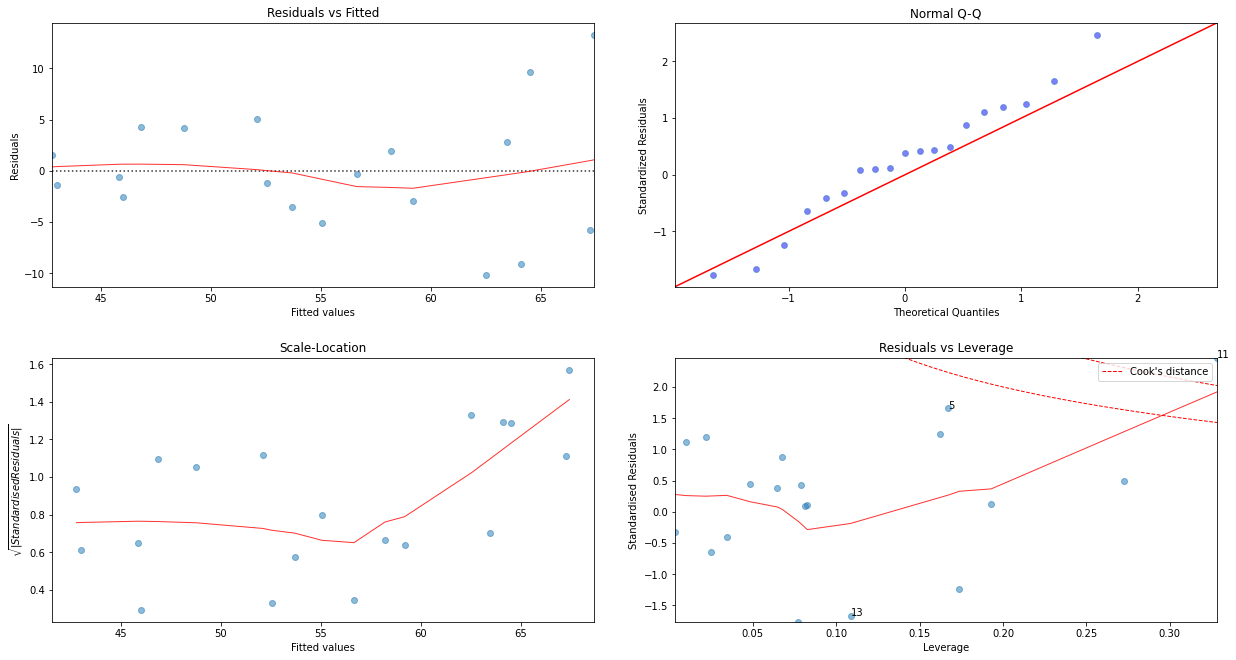

In [72]:
clml.diagnostic_plots(x_test, y_test, y_score)

# XGBoost

In [73]:
# set up parameter grid
xgbm_param_grid = {
    "learning_rate": [0.01, 0.1, 0.3, 0.6, 0.9],
    "n_estimators": [25, 50, 100, 150],
    "subsample": [0.3, 0.5, 0.9],
    "colsample_bytree": [0.3, 0.5, 0.7],
    "gamma": [0.3, 0.5, 0.7],
    "max_depth": [3, 5, 7, 9],
    "objective": ["reg:squarederror"],
}

In [74]:
k_fold = KFold(n_splits=3)
model_xgb = xgb.XGBRegressor()

In [75]:
grid_mse = GridSearchCV(
    estimator=model_xgb,
    param_grid=xgbm_param_grid,
    scoring="neg_mean_squared_error",
    cv=k_fold,
    verbose=1,
    n_jobs=8,
)

In [76]:
grid_mse.fit(x_train, y_train)

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mo...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=8,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'gamma': [

In [77]:
# print the best parameters and lowest RMSE
print(f"Best parameters found: {grid_mse.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(grid_mse.best_score_)):0.2f}")

Best parameters found: {'colsample_bytree': 0.3, 'gamma': 0.5, 'learning_rate': 0.9, 'max_depth': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
Lowest RMSE found: 7.66


In [78]:
# use best parameters
model_xgb = xgb.XGBRegressor(
    colsample_bytree=0.3,
    gamma=0.5,
    learning_rate=0.9,
    max_depth=7,
    n_estimators=100,
    subsample=0.5,
)

In [79]:
# fit model
model_xgb_fit = model_xgb.fit(x_train, y_train)

In [80]:
y_hat = model_xgb_fit.predict(x_train)
clml.regression_metrics(y_train, y_hat, p)

Root Mean Square Error = 0.31
Mean Absolute Error    = 0.26
Median Absolute Error  = 0.23
R^2                    = 0.9987
Adjusted R^2           = 0.9987


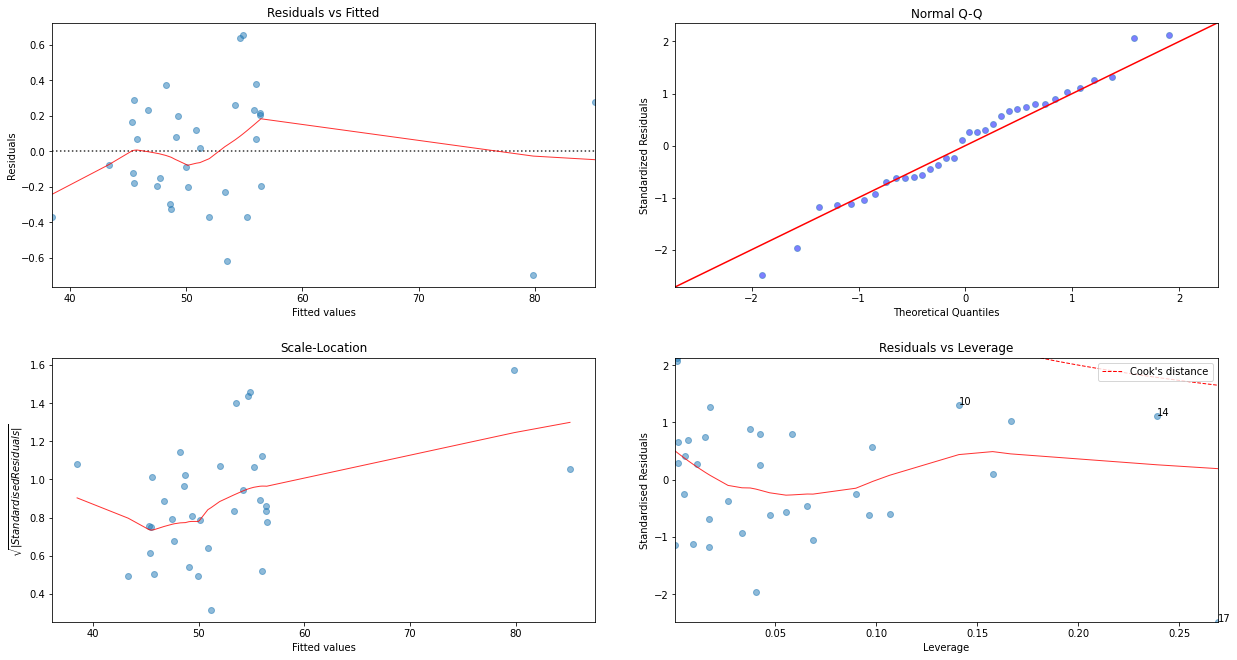

In [81]:
clml.diagnostic_plots(x_train, y_train, y_hat)

In [82]:
y_score = model_xgb_fit.predict(x_test)
clml.regression_metrics(y_test, y_score, p)

Root Mean Square Error = 6.03
Mean Absolute Error    = 4.70
Median Absolute Error  = 2.95
R^2                    = 0.5136
Adjusted R^2           = 0.4850


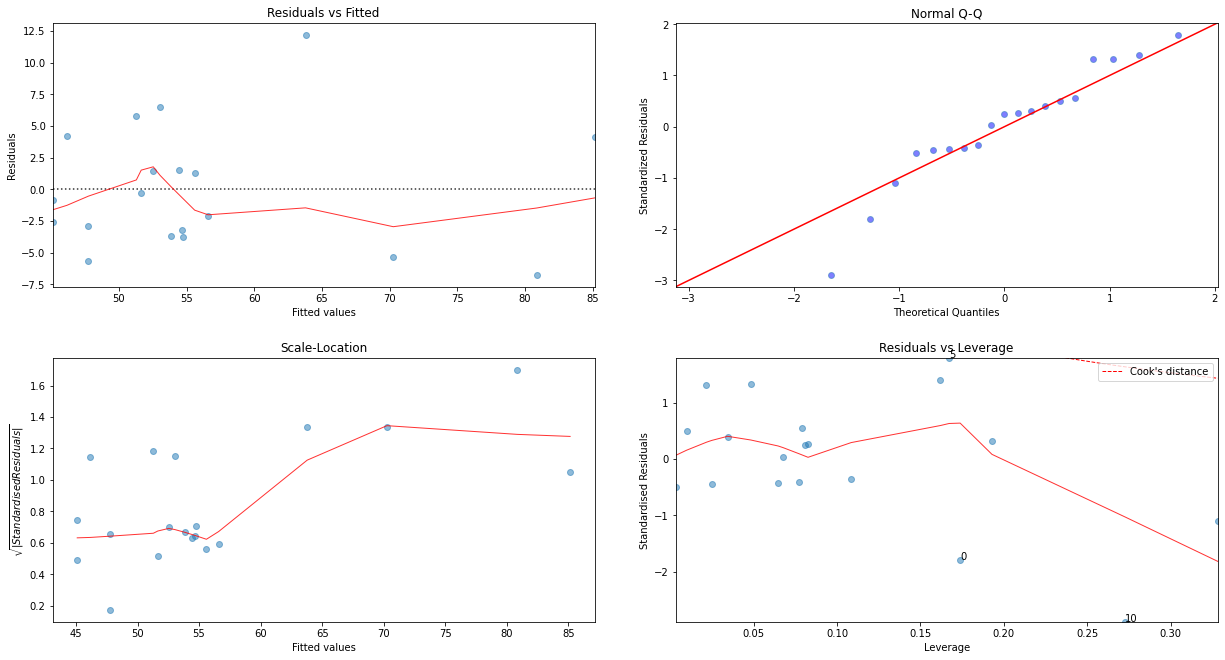

In [83]:
clml.diagnostic_plots(x_test, y_test, y_score)

In [84]:
#explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model_xgb_fit)
shap_values = explainer.shap_values(x_train)

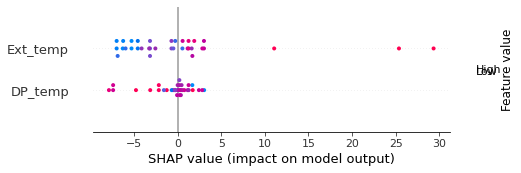

In [85]:
#summarize the effects of all the features
shap.summary_plot(shap_values, x_train, feature_names=feat_cols)

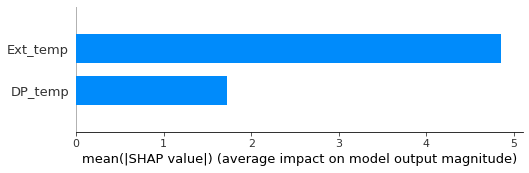

In [86]:
shap.summary_plot(shap_values, x_train, plot_type='bar', feature_names=feat_cols)

In [87]:
# save model model
joblib.dump(model_xgb_fit, "../models/model_predict_xgboost.pkl")

['../models/model_predict_xgboost.pkl']

In [88]:
SEmodel = math.sqrt(sklm.mean_squared_error(y_test, y_score))
print(f"Standard error of the model is {SEmodel:0.2f}")

Standard error of the model is 6.03


## Calculate energy performance

In [89]:
# split features into numpy array
features_rp = np.array(df_rp[feat_cols])
print(features_rp.shape)

(61, 2)


In [90]:
# import models for reporting period
scaler = joblib.load("../models/model_feature_scaling.pkl")
model_opt = joblib.load("../models/model_predict_xgboost.pkl")

In [91]:
x_rp = scaler.transform(features_rp[:, :])
x_rp[:5, :]

array([[-2.89237692,  0.67531193],
       [-3.91553892,  1.54799525],
       [-4.16184347,  1.11148453],
       [-4.23618792,  0.75233212],
       [-4.44913483,  0.94744471]])

In [92]:
# predict expected consumption
y_rp = model_opt.predict(x_rp)

In [93]:
df_rp["ExpectedkWh"] = y_rp

df_rp["Residuals"] = df_rp.DP_energy - df_rp.ExpectedkWh
df_rp["CUSUM"] = df_rp.Residuals.cumsum()

df_rp["TargetkWh"] = df_rp.ExpectedkWh * 0.97
df_rp["ResidualsT"] = df_rp.TargetkWh - df_rp.ExpectedkWh
df_rp["CUSUMT"] = df_rp.ResidualsT.cumsum()

print(
    "Cumulative performance against actual: {0:,.0f} kWh".format(
        df_rp["CUSUM"].tail(1).values[0]
    )
)

Cumulative performance against actual: 281 kWh


In [94]:
traceE = go.Scatter(
    x=df_rp.index, y=df_rp.CUSUM, name="Cumulative energy performance [kWh]"
)

layout = go.Layout(
    legend=dict(orientation="h"),
    title="Cumulative energy performance",
    xaxis=dict(
        title="",
        titlefont=dict(
            # size=18,
            color="#7f7f7f"
        ),
    ),
    yaxis=dict(
        title="Cumulative energy [kWh]",
        titlefont=dict(
            # size=18,
            color="#7f7f7f"
        ),
    ),
)
data = [traceE]
fig = go.Figure(data=data, layout=layout)
fig.show()

In [95]:
no_of_days = len(df_rp.index)
additional_energy = df_rp["CUSUM"].tail(1).values[0]
additional_energy_per_day = additional_energy / no_of_days
print(additional_energy_per_day)

4.602310562285852


In [96]:
print(f"Additional energy is {additional_energy_per_day:0.2f} kWh per day")
print(f"Over a year, that equates to {additional_energy_per_day*365:0.0f} kWh per annum")
print(f"That is approximately a reduction of {additional_energy_per_day*365*1.04:0.0f} kg CO2e and saving R {additional_energy_per_day*365*1.80:0.0f} per annum")

Additional energy is 4.60 kWh per day
Over a year, that equates to 1680 kWh per annum
That is approximately a reduction of 1747 kg CO2e and saving R 3024 per annum


- The results from the energy model is just below 50% of the average estimates using in the EDA notebook.
- Thus, using proper models to estimate savings and adjusting for the various factors is important to ensure savings are realistic to motivate for interventions.
- Another important note is that we have a few months of data only and don't cover all the seasonal variations and thus the baseline may not be representative.